# Transfer Learning

Transfer Learning leverages a pretrained model that is already extremely performant on general feature detection. Our work will be to re-train this model on our specific dataset and add the specialized knowledge needed to solve our task.

Since the model is already pre-trained we can expect that we will only need about `10%` of the amount of data that would be needed to train a fresh model.

## Feature Extraction

* cd datasets
* wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
* unzip 10_food_classes_10_percent.zip && rm 10_food_classes_10_percent.zip

```
tree -L 2
10_food_classes_10_percent
├── test
│   ├── chicken_curry
│   ├── chicken_wings
│   ├── fried_rice
│   ├── grilled_salmon
│   ├── hamburger
│   ├── ice_cream
│   ├── pizza
│   ├── ramen
│   ├── steak
│   └── sushi
└── train
    ├── chicken_curry
    ├── chicken_wings
    ├── fried_rice
    ├── grilled_salmon
    ├── hamburger
    ├── ice_cream
    ├── pizza
    ├── ramen
    ├── steak
    └── sushi
```

### Visualizing the Data

In [1]:
import datetime
import itertools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

2023-03-07 13:32:47.775875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 13:32:48.459249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-07 13:32:48.459274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
# check if you have GPU support
tf.config.list_physical_devices('GPU')
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#   tf.config.experimental.set_memory_growth(device, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# set directories
training_directory = "../datasets/10_food_classes_10_percent/train/"
testing_directory = "../datasets/10_food_classes_10_percent/test/"

# get class names
data_dir = pathlib.Path(training_directory)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
len(class_names), class_names 

# the data set has 10 classes:
# (10,
#  array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
#         'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
#        dtype='<U14'))

(10,
 array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
        'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
       dtype='<U14'))

2023-03-07 13:26:31.011846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 13:26:31.013425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 13:26:31.013643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-07 13:26:31.013806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

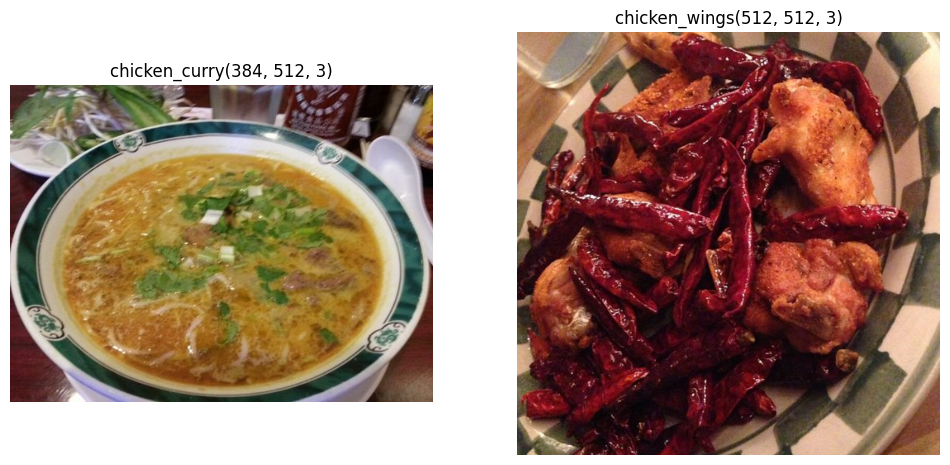

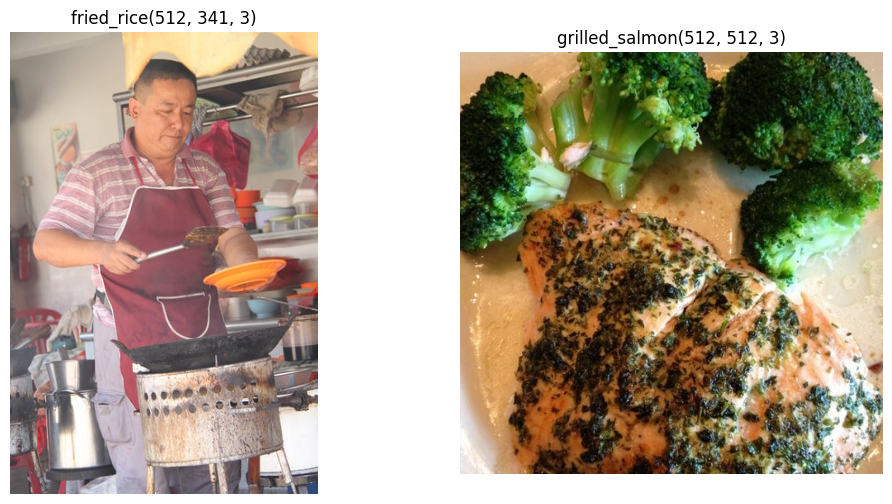

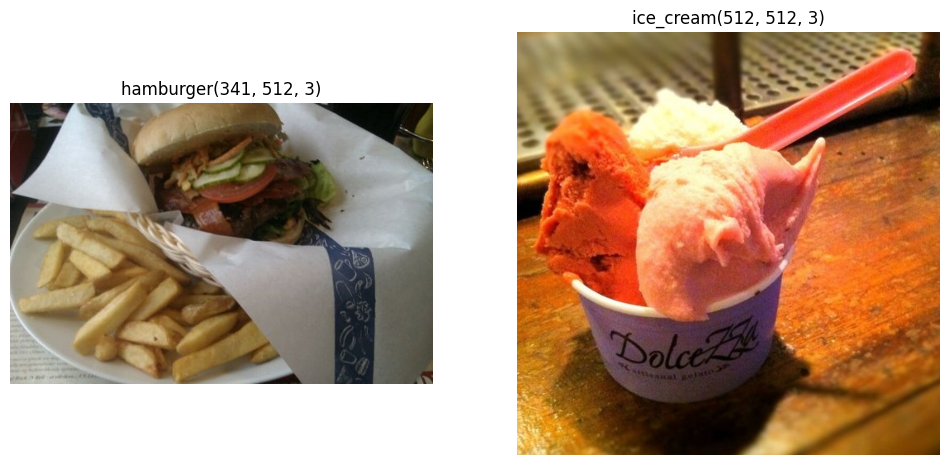

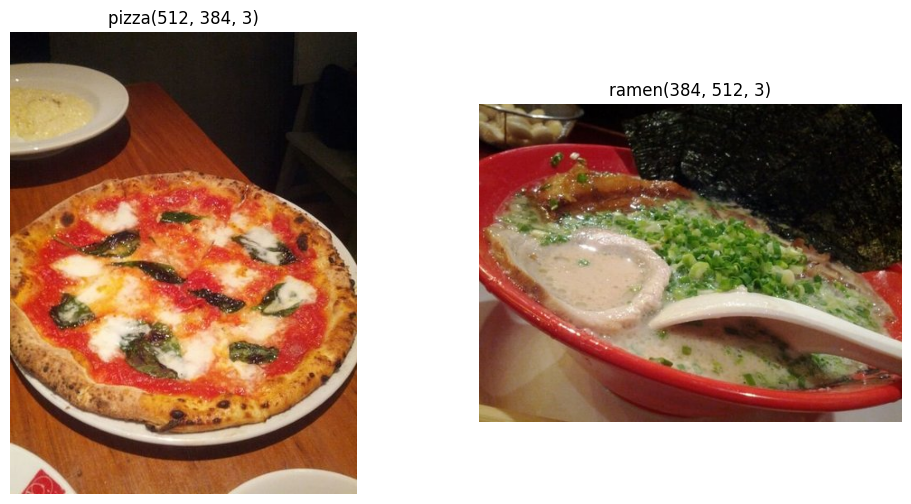

In [8]:
# visualizing the dataset
## display random images
def view_random_image(target_dir, target_class):
    target_folder = str(target_dir) + "/" + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(str(target_class) + str(img.shape))
    plt.axis("off")
    
    return tf.constant(img)

fig = plt.figure(figsize=(12, 6))
plot1 = fig.add_subplot(1, 2, 1)
plot1.title.set_text(f'Class: {class_names[0]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[0])
plot2 = fig.add_subplot(1, 2, 2)
plot2.title.set_text(f'Class: {class_names[1]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[1])

fig = plt.figure(figsize=(12, 6))
plot3 = fig.add_subplot(1, 2, 1)
plot3.title.set_text(f'Class: {class_names[2]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[2])
plot4 = fig.add_subplot(1, 2, 2)
plot4.title.set_text(f'Class: {class_names[3]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[3])

fig = plt.figure(figsize=(12, 6))
plot5 = fig.add_subplot(1, 2, 1)
plot5.title.set_text(f'Class: {class_names[4]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[4])
plot6 = fig.add_subplot(1, 2, 2)
plot6.title.set_text(f'Class: {class_names[5]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[5])

fig = plt.figure(figsize=(12, 6))
plot7 = fig.add_subplot(1, 2, 1)
plot7.title.set_text(f'Class: {class_names[6]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[6])
plot8 = fig.add_subplot(1, 2, 2)
plot8.title.set_text(f'Class: {class_names[7]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[7])

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_01.png)

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_02.png)

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_03.png)

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_04.png)

### Preprocessing the Data

In [17]:
SEED = 42
BATCH_SIZE = 16
IMG_SHAPE = (224, 224)

training_data = image_dataset_from_directory(training_directory,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

testing_data = image_dataset_from_directory(testing_directory,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)


# this time we only work with 10% of the training dataset
# Found 750 files belonging to 10 classes.
# Found 2500 files belonging to 10 classes.

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### TensorBoard Perfomance Tracking

In [10]:
# create a callback to track experiments in TensorBoard
def create_tensorboard_callback(dir_name, experiment_name):
    # log progress to log directory
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print(f"Saving TensorBoard Log to: {log_dir}")
    return tensorboard_callback

### Building a Model from Tensorflow Hub

Pick a well performing model from the [Image Classification Leaderboard](https://paperswithcode.com/task/image-classification) and try to find it on:

* [Tensorflow Hub](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0,resnet-v2-50&tf-version=tf2)
  * [EfficientNetB0 (feature-vector)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)
  * [ResNetv250 (feature_vector)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5)

In [11]:
# model comparison
resnet_model_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_model_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [13]:
# add image augmentations (optional)
data_augmentation_layer = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

# helper function to create a model
def create_model(model_url, num_classes):
    # download pre-trained model as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='feature_extractor_layer')
    
    # create sequential model
    model = tf.keras.Sequential([
        Rescaling(1./255, input_shape=IMG_SHAPE+(3,)),
        # data_augmentation_layer,
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

### Creating a ResNet-based Model

In [14]:
resnet_model = create_model(resnet_model_url, len(class_names))

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(learning_rate=1e-3),
                     metrics=["accuracy"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
resnet_model.summary()

# Model: "sequential_1"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling (Rescaling)       (None, 224, 224, 3)       0         
#  feature_extractor_layer (Ke (None, 2048)             23564800  
#  rasLayer)
#  output_layer (Dense)        (None, 10)                20490
# =================================================================
# Total params: 23,585,290
# Trainable params: 20,490
# Non-trainable params: 23,564,800
# _________________________________________________________________

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Training the ResNet Model

In [18]:
tf.random.set_seed(SEED)
# fitting the model
history_resnet_model = resnet_model.fit(training_data, epochs=5,
                            steps_per_epoch=len(training_data),
                            validation_data=testing_data,
                            validation_steps=len(testing_data))

# Epoch 15/15
# 12s 531ms/step - loss: 5.6705 - accuracy: 0.6680 - val_loss: 22.5076 - val_accuracy: 0.2684

Epoch 1/5


2023-03-07 13:30:35.371088: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-07 13:30:35.513347: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-03-07 13:30:35.513410: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_1' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/xiaodie/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/xiaodie/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/xiaodie/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/xiaodie/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/xiaodie/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/xiaodie/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/xiaodie/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/xiaodie/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/xiaodie/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_102209/2450213707.py", line 3, in <module>
      history_resnet_model = resnet_model.fit(training_data, epochs=5,
    File "/usr/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/usr/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_1'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_1}}]] [Op:__inference_train_function_18578]

### Creating a EfficientNet-based Model

In [9]:
efficientnet_model = create_model(efficientnet_model_url, len(class_names))

efficientnet_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

In [10]:
efficientnet_model.summary()

# Model: "sequential_2"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
#  feature_extractor_layer (Ke (None, 1280)             4049564   
#  rasLayer)                                                       
#  output_layer (Dense)        (None, 10)                12810     
# =================================================================
# Total params: 4,062,374
# Trainable params: 12,810
# Non-trainable params: 4,049,564
# _________________________________________________________________

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Training the EfficientNet Model

In [73]:
tf.random.set_seed(SEED)
# fitting the model
history_efficientnet_model = efficientnet_model.fit(training_data, epochs=15,
                            steps_per_epoch=len(training_data),
                            validation_data=testing_data,
                            validation_steps=len(testing_data))

# Epoch 15/15
# 24/24 [==============================] - 10s 426ms/step - loss: 22.2573 - accuracy: 0.6880 - val_loss: 542.0494 - val_accuracy: 0.1132

Epoch 1/15
24/24 [==============================] - 12s 450ms/step - loss: 62.7687 - accuracy: 0.4653 - val_loss: 483.8928 - val_accuracy: 0.1160
Epoch 2/15
24/24 [==============================] - 10s 410ms/step - loss: 50.1972 - accuracy: 0.4960 - val_loss: 504.6476 - val_accuracy: 0.1232
Epoch 3/15
24/24 [==============================] - 10s 422ms/step - loss: 44.5023 - accuracy: 0.5147 - val_loss: 483.9654 - val_accuracy: 0.1116
Epoch 4/15
24/24 [==============================] - 10s 417ms/step - loss: 43.6589 - accuracy: 0.5360 - val_loss: 512.9346 - val_accuracy: 0.1172
Epoch 5/15
24/24 [==============================] - 10s 411ms/step - loss: 32.5574 - accuracy: 0.5640 - val_loss: 490.1364 - val_accuracy: 0.1128
Epoch 6/15
24/24 [==============================] - 10s 409ms/step - loss: 37.8192 - accuracy: 0.5707 - val_loss: 516.5619 - val_accuracy: 0.1212
Epoch 7/15
24/24 [==============================] - 10s 425ms/step - loss: 45.3500 - accuracy: 0.5640 - val_loss: 537.7586 -

### Comparing both Models

<AxesSubplot: title={'center': 'EfficientNet Model (Multiclass)'}>

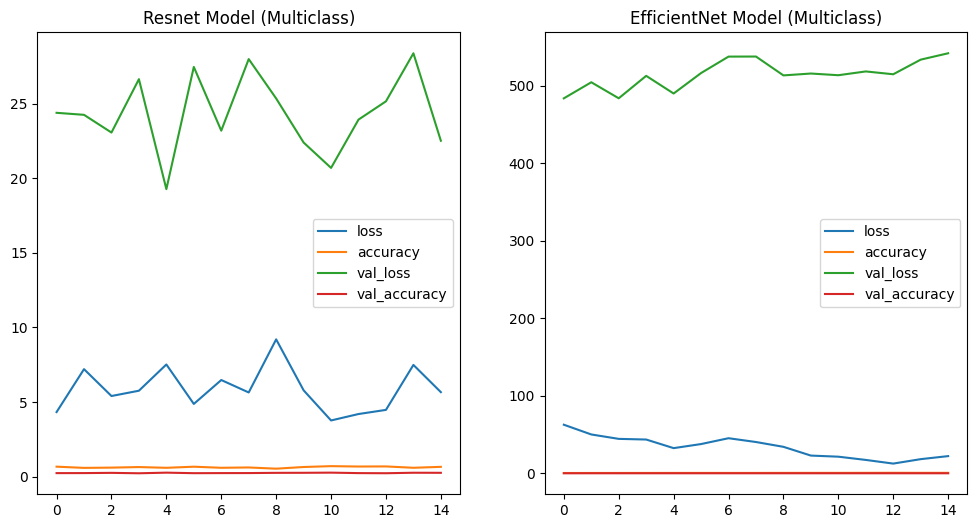

In [74]:
# plotting the loss curves
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_resnet_model.history).plot(ax=axes[0], title="Resnet Model (Multiclass)")
pd.DataFrame(history_efficientnet_model.history).plot(ax=axes[1], title="EfficientNet Model (Multiclass)")

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_05.png)

In [75]:
# Plot the validation and training accuracy separately
def plot_accuracy_curves(history1, title1, history2, title2):
  accuracy1 = history1.history['accuracy']
  val_accuracy1 = history1.history['val_accuracy']
  epochs1 = range(len(history1.history['accuracy']))

  accuracy2 = history2.history['accuracy']
  val_accuracy2 = history2.history['val_accuracy']
  epochs2 = range(len(history2.history['accuracy']))

  # Plot accuracy
  plt.figure(figsize=(12, 12))
    
  plt.subplot(2, 2, 1)
  plt.plot(epochs1, accuracy1, label='training_accuracy')
  plt.plot(epochs1, val_accuracy1, label='val_accuracy')
  plt.title(title1)
  plt.xlabel('Epochs')
  plt.legend();

  plt.subplot(2, 2, 2)
  plt.plot(epochs2, accuracy2, label='training_accuracy')
  plt.plot(epochs2, val_accuracy2, label='val_accuracy')
  plt.title(title2)
  plt.xlabel('Epochs')
  plt.legend();

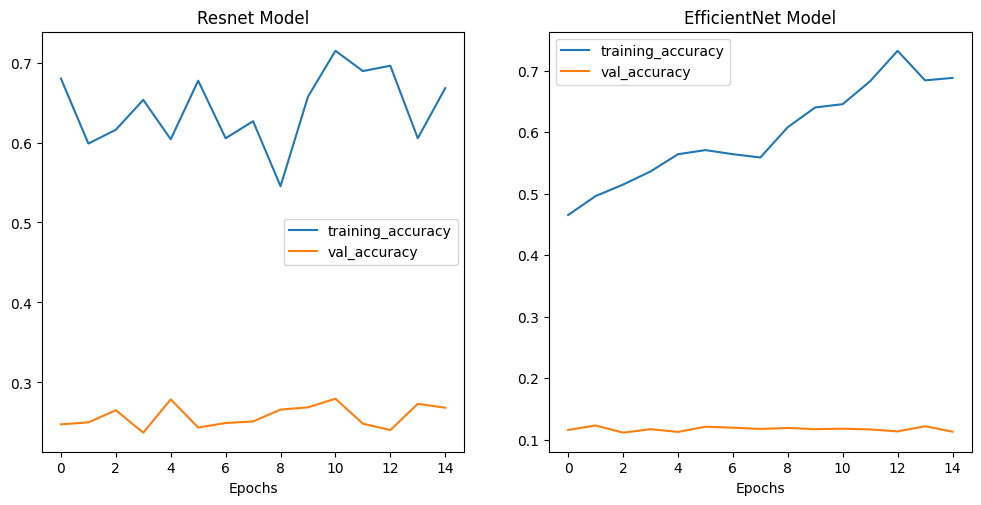

In [76]:
# plotting the accuracy curves
plot_accuracy_curves(history1=history_resnet_model,
                     title1="Resnet Model",
                     history2=history_efficientnet_model,
                     title2="EfficientNet Model")

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_06.png)

### Using the Tensorboard Callback

In [68]:
tf.random.set_seed(SEED)
# re-running the resnet training
history_resnet_model = resnet_model.fit(training_data, epochs=15,
        callbacks=create_tensorboard_callback(dir_name='../tensorboard/resnet',
                                              experiment_name='resnet_01'),
        steps_per_epoch=len(training_data),
        validation_data=testing_data,
        validation_steps=len(testing_data))

# Epoch 15/15
# 24/24 [==============================] - 13s 573ms/step - loss: 8.2926 - accuracy: 0.5573 - val_loss: 25.3469 - val_accuracy: 0.2252

Saving TensorBoard Log to: resnet/resnet_01/20230306-182913
Epoch 1/15
24/24 [==============================] - 14s 565ms/step - loss: 15.6790 - accuracy: 0.4027 - val_loss: 27.4477 - val_accuracy: 0.2368
Epoch 2/15
24/24 [==============================] - 13s 558ms/step - loss: 12.0422 - accuracy: 0.4280 - val_loss: 26.1270 - val_accuracy: 0.2272
Epoch 3/15
24/24 [==============================] - 13s 576ms/step - loss: 15.6178 - accuracy: 0.3973 - val_loss: 26.0636 - val_accuracy: 0.2428
Epoch 4/15
24/24 [==============================] - 14s 583ms/step - loss: 16.1148 - accuracy: 0.4387 - val_loss: 24.8996 - val_accuracy: 0.2376
Epoch 5/15
24/24 [==============================] - 13s 575ms/step - loss: 13.6614 - accuracy: 0.4160 - val_loss: 25.1141 - val_accuracy: 0.2536
Epoch 6/15
24/24 [==============================] - 13s 562ms/step - loss: 14.6404 - accuracy: 0.4320 - val_loss: 22.7228 - val_accuracy: 0.2612
Epoch 7/15
24/24 [==============================] - 14s 583ms/step - l

In [70]:
tf.random.set_seed(SEED)
# re-running the resnet training
history_resnet_model = resnet_model.fit(training_data, epochs=15,
            callbacks=create_tensorboard_callback(dir_name='../tensorboard/efficientnet',
                                                  experiment_name='efficientnet_01'),
            steps_per_epoch=len(training_data),
            validation_data=testing_data,
            validation_steps=len(testing_data))

# Epoch 15/15
# 24/24 [==============================] - 16s 680ms/step - loss: 6.3984 - accuracy: 0.6387 - val_loss: 22.5422 - val_accuracy: 0.2764

Saving TensorBoard Log to: efficientnet/efficientnet_01/20230306-183336
Epoch 1/15
24/24 [==============================] - 16s 684ms/step - loss: 10.6049 - accuracy: 0.5013 - val_loss: 21.8567 - val_accuracy: 0.2516
Epoch 2/15
24/24 [==============================] - 15s 653ms/step - loss: 8.5189 - accuracy: 0.5373 - val_loss: 26.9186 - val_accuracy: 0.2296
Epoch 3/15
24/24 [==============================] - 15s 647ms/step - loss: 13.1343 - accuracy: 0.4867 - val_loss: 28.2634 - val_accuracy: 0.2204
Epoch 4/15
24/24 [==============================] - 16s 682ms/step - loss: 10.1007 - accuracy: 0.5333 - val_loss: 29.6053 - val_accuracy: 0.2288
Epoch 5/15
24/24 [==============================] - 15s 657ms/step - loss: 11.1407 - accuracy: 0.4893 - val_loss: 25.0870 - val_accuracy: 0.2792
Epoch 6/15
24/24 [==============================] - 16s 670ms/step - loss: 9.3750 - accuracy: 0.5320 - val_loss: 23.3094 - val_accuracy: 0.2716
Epoch 7/15
24/24 [==============================] - 16s 694m

2023-03-06 19:57:14.074356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 19:57:14.095164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-06 19:57:14.095773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]